## Thêm các thư viện cần thiết

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from collections import Counter

## Đọc dữ liệu

In [2]:
df = pd.read_csv('heart.csv')

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


## Kiểm tra cân bằng dữ liệu


In [6]:
df_y = pd.DataFrame(df.HeartDisease.value_counts())
df_y['percent'] = round(df_y.HeartDisease/sum(df_y.HeartDisease)*100, 2)
df_y

,HeartDisease,percent
1,508,55.34
0,410,44.66


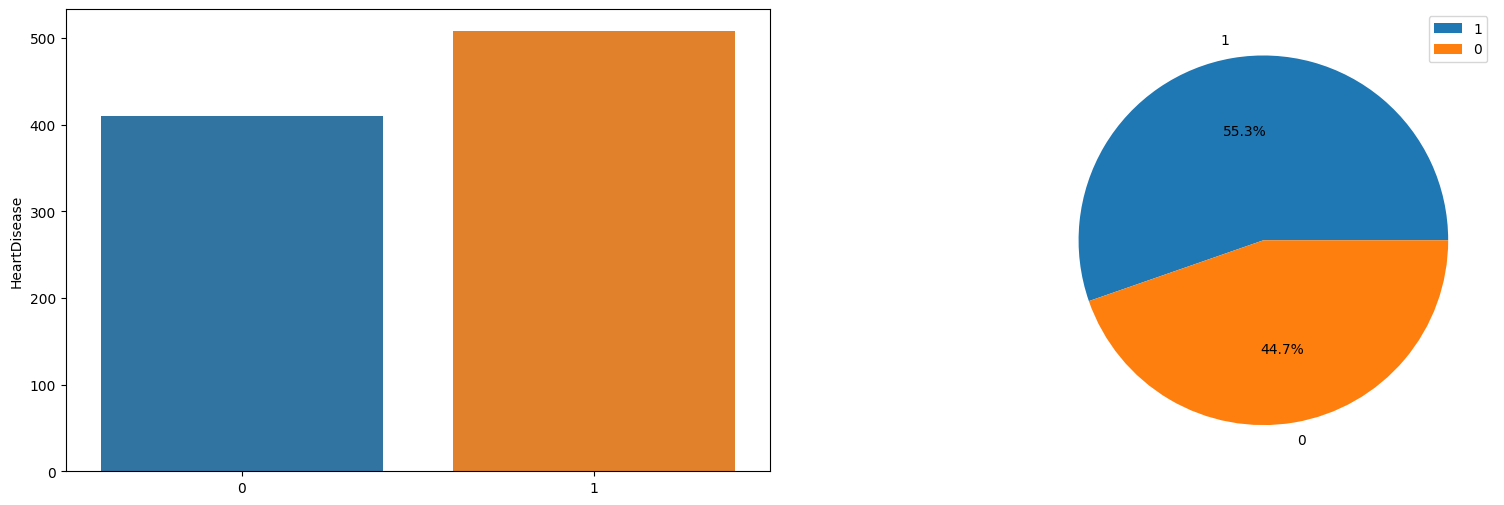

In [7]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.barplot(data = df_y, x = df_y.index, y = df_y.HeartDisease)
plt.subplot(1,2,2)
plt.pie(df_y.HeartDisease, labels = df_y.index, autopct='%1.1f%%')
plt.legend()

## Kiểm tra Outliers

In [8]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [9]:
num_columns = df.select_dtypes(exclude='object')
num_columns.drop('HeartDisease', axis=1, inplace = True)
cate_columns = df.select_dtypes(include='object')
num_columns

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
0,40,140,289,0,172,0.0
1,49,160,180,0,156,1.0
2,37,130,283,0,98,0.0
3,48,138,214,0,108,1.5
4,54,150,195,0,122,0.0
...,...,...,...,...,...,...
913,45,110,264,0,132,1.2
914,68,144,193,1,141,3.4
915,57,130,131,0,115,1.2
916,57,130,236,0,174,0.0


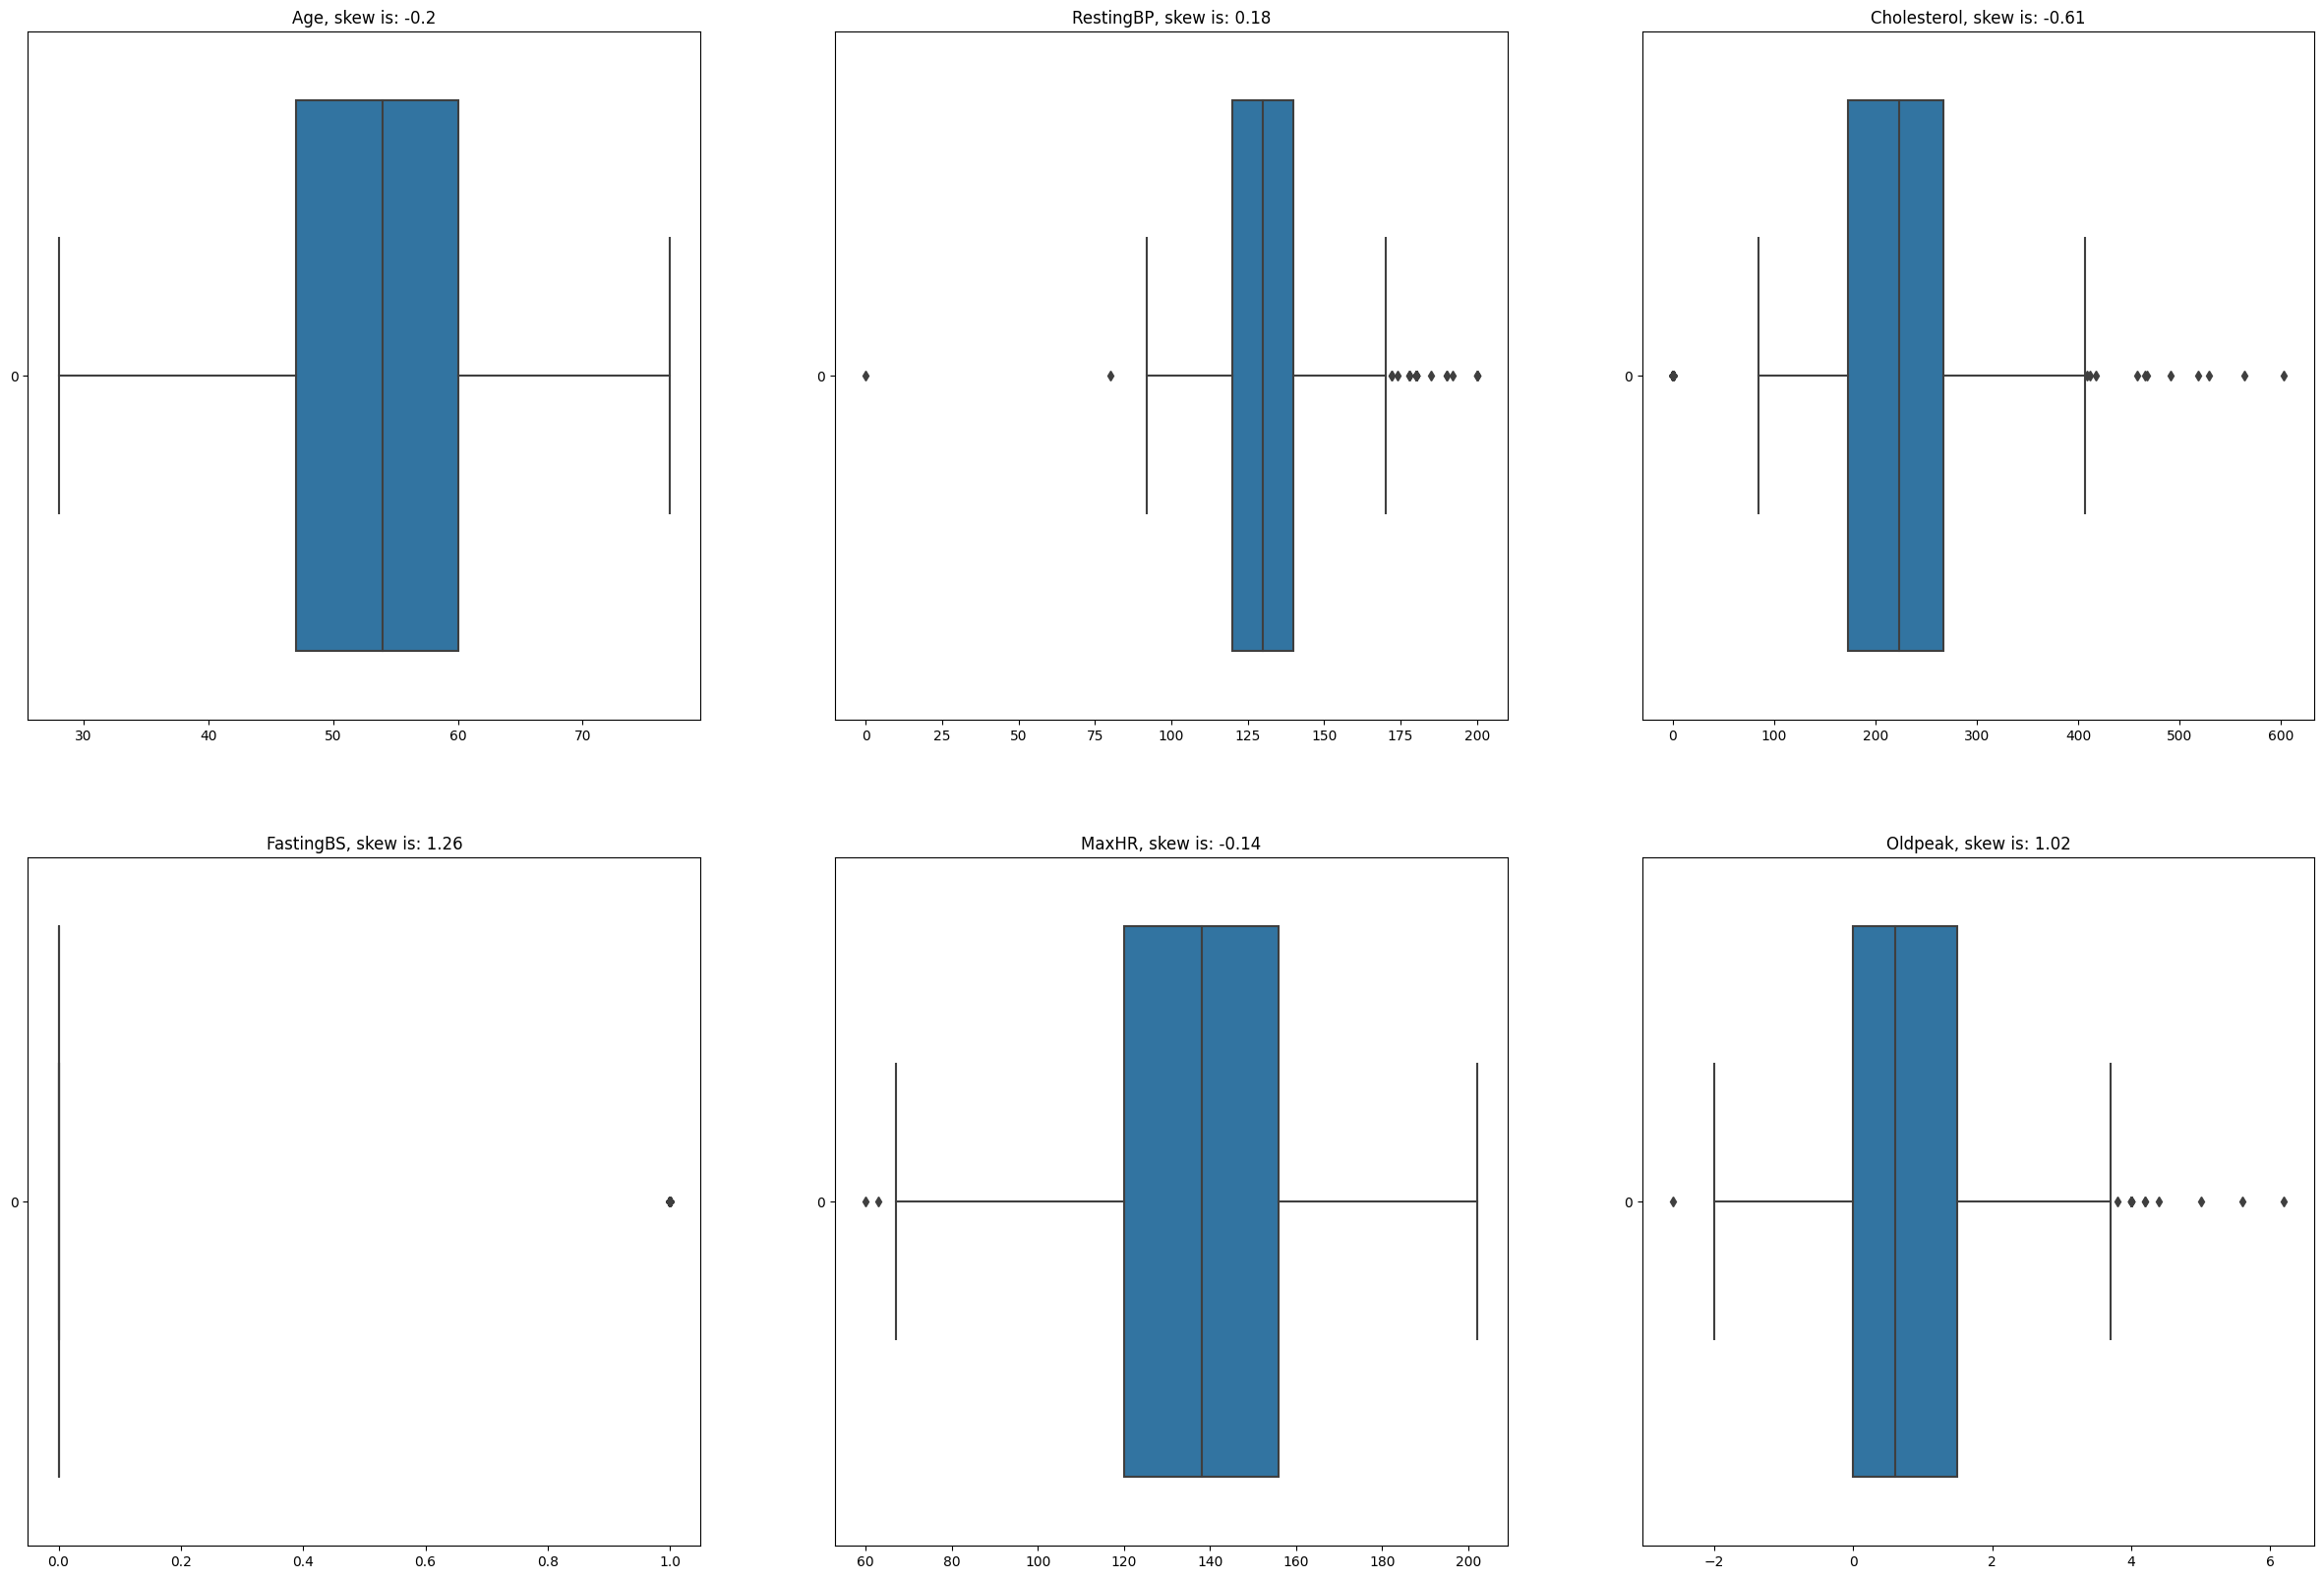

In [10]:
from scipy.stats import skew
plt.figure(figsize = (30,20))
for i in range(len(num_columns.columns)):
    #print(i+1)
    plt.subplot(2,3,i+1)
    sns.boxplot(data = num_columns.iloc[:, i], orient='h')
    plt.title(str(num_columns.columns[i]) + ', skew is: ' + str(round(skew(num_columns.iloc[:,i]), 2) ))

In [11]:
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column],75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        outlier_list.extend(outlier_list_column)
        
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

## Xóa Outliers

In [12]:
# detecting outliers
Outliers_IQR = IQR_method(df,1,num_columns)

# dropping outliers
df = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 16


## Dummies

In [13]:
df = pd.get_dummies(df, drop_first=True)

## Tách tập train, test

In [14]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

In [16]:
from sklearn.preprocessing import StandardScaler

def standard_scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    df[col_names] = features
    
    return df

In [17]:
col_names = num_columns.columns
X_train = standard_scaler (X_train, col_names)
X_test = standard_scaler (X_test, col_names)
X_train

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
746,-1.114716,-0.709355,-0.535199,-0.414111,-0.736659,1.611751,1,0,0,0,0,0,1,1,0
423,0.828374,-0.709355,0.674669,-0.414111,-0.129263,3.075962,1,0,0,0,0,1,1,0,0
570,0.612475,2.584903,0.294425,-0.414111,0.194681,-0.828600,0,0,0,0,1,0,1,1,0
274,-0.251121,0.205716,-0.731083,-0.414111,0.478132,1.123681,1,0,1,0,1,0,0,1,0
133,0.828374,-0.099308,0.812939,-0.414111,-0.736659,0.147540,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,-0.359070,-1.319403,-0.247135,-0.414111,0.275667,-0.828600,0,1,0,0,1,0,0,0,1
730,1.260172,0.205716,0.352037,-0.414111,-0.453208,1.904593,1,0,0,0,0,0,0,1,0
226,-1.330615,-0.709355,0.824462,-0.414111,1.287993,-0.828600,1,1,0,0,1,0,0,0,1
90,-0.467019,-1.319403,-0.178000,-0.414111,0.883062,-0.828600,0,1,0,0,1,0,0,0,1


In [18]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [19]:
kf = KFold(n_splits=5, shuffle=False)

## Xây dựng model

In [20]:
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [21]:
y_pred = rf.predict(X_test)

In [22]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score, classification_report
cm = confusion_matrix(y_test, y_pred)

rf_Recall = recall_score(y_test, y_pred)
rf_Precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[109  12]
 [ 15 107]]


In [23]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.879032,0.900826,0.889796,121.000000
1,0.899160,0.877049,0.887967,122.000000
accuracy,0.888889,0.888889,0.888889,0.888889
macro avg,0.889096,0.888938,0.888881,243.000000
weighted avg,0.889137,0.888889,0.888878,243.000000


## Kiểm định chéo

In [24]:
score = cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')
print(score)
print('Avarage:', np.mean(score))
print('Std', np.std(score))

[0.81666667 0.85106383 0.76923077 0.82539683 0.88      ]
Avarage: 0.828471618216299
Std 0.03694285201066895


In [25]:
ndf = [(rf_Recall, rf_Precision, rf_f1, rf_accuracy, np.mean(score), np.std(score))]

rf_score = pd.DataFrame(data = ndf, columns=
                        ['Recall','Precision','F1 Score', 'Accuracy', 'Avg CV Recall', 'Standard CV Recall'])
rf_score.insert(0, 'Random Forest', 'Before')
rf_score

,Random Forest,Recall,Precision,F1 Score,Accuracy,Avg CV Recall,Standard CV Recall
0,Before,0.877049,0.89916,0.887967,0.888889,0.828472,0.036943


## Sử dụng GridSearchCV để tìm ra tham số tốt nhất

In [26]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [130,150,170,190,200],
    'max_depth': [8,10,12,14],
    'min_samples_split': [3,4,5,6],
    'min_samples_leaf': [1,2,3],
    'random_state': [13, 42, 0]
}

grid_rf = GridSearchCV(rf, param_grid=params, cv=kf, 
                          scoring='recall').fit(X_train, y_train)

In [27]:
print('Best parameters:', grid_rf.best_params_)
print('Best score:', grid_rf.best_score_)

Best parameters: {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 150, 'random_state': 13}
Best score: 0.8651727327046477


In [28]:
y_pred = grid_rf.predict(X_test)

In [29]:
cm = confusion_matrix(y_test, y_pred)

grid_rf_Recall = recall_score(y_test, y_pred)
grid_rf_Precision = precision_score(y_test, y_pred)
grid_rf_f1 = f1_score(y_test, y_pred)
grid_rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[111  10]
 [ 13 109]]


## Kiểm định chéo

In [ ]:
score2 = cross_val_score(grid_rf, X_train, y_train, cv=kf, scoring='recall')

In [ ]:
ndf2 = [(grid_rf_Recall, grid_rf_Precision, grid_rf_f1, grid_rf_accuracy, np.score(score2), np.std(score2))]

grid_score = pd.DataFrame(data = ndf2, columns=
                        ['Recall','Precision','F1 Score', 'Accuracy', 'Avg CV Recall', 'Standard CV Recall'])
grid_score.insert(0, 'Random Forest', 'After')
grid_score

## So sánh trước và sau khi điều chỉnh tham số

In [ ]:
predictions = pd.concat([rf_score, grid_score], ignore_index=True)
predictions